In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from scipy.stats import skew, kurtosis

In [2]:
train = pd.read_csv('data/train_clean.csv')
test = pd.read_csv('data/test_clean.csv', delimiter=';')

In [3]:
pay_cols = ['PAY_JUL', 'PAY_AUG', 'PAY_SEP', 'PAY_OCT', 'PAY_NOV', 'PAY_DEC']
bill_amt_cols = ['BILL_AMT_JUL', 'BILL_AMT_AUG', 'BILL_AMT_SEP', 'BILL_AMT_OCT', 'BILL_AMT_NOV', 'BILL_AMT_DEC']
pay_amt_cols = ['PAY_AMT_JUL', 'PAY_AMT_AUG', 'PAY_AMT_SEP', 'PAY_AMT_OCT', 'PAY_AMT_NOV', 'PAY_AMT_DEC']

avg_pay_last = ['AVG_PAY_LAST_2', 'AVG_PAY_LAST_3', 'AVG_PAY_LAST_4', 'AVG_PAY_LAST_5', 'AVG_PAY_LAST_6']
avg_bill_last = ['AVG_BILL_LAST_2', 'AVG_BILL_LAST_3', 'AVG_BILL_LAST_4', 'AVG_BILL_LAST_5', 'AVG_BILL_LAST_6']

## Sex

In [4]:
for df in [train, test]:
    df['SEX_MISSING'] = df['SEX'].isnull()*1      # Add a column to say if sex was missing or not
    df.loc[df['SEX'].isnull(), 'SEX'] = 'F' # Predict sex with majority class
    df['SEX'] = df['SEX'].apply(lambda x : 0 if x == 'M' else 1)   # Convert to M -> 0, F -> 1

## Education

In [5]:
for df in [train, test]:
    df['EDUCATION_MISSING'] = df['EDUCATION'].isnull() * 1 # Add a column to say if education was missing or not
    df['EDUCATION'] = df['EDUCATION'].fillna('other')    # Predict missing values as other

train = pd.get_dummies(train, columns=['EDUCATION'])   # Get one hot vector for education
test = pd.get_dummies(test, columns=['EDUCATION'])

## Marriage

In [6]:
for df in [train, test]:
    df['MARRIAGE_MISSING'] = df['MARRIAGE'].isnull() * 1 # Add a column to say if education was missing or not
    df['MARRIAGE'] = df['MARRIAGE'].fillna('other')    # Predict missing values as other

train = pd.get_dummies(train, columns=['MARRIAGE'])   # Get one hot vector for education
test = pd.get_dummies(test, columns=['MARRIAGE'])   # Get one hot vector for education


## Age

In [7]:
import datetime

def get_age(date):
    try:
        if len(date) == 10:
            return (datetime.datetime.today() - datetime.datetime.strptime(date, '%d/%m/%Y')).days//365
        else:
            return (datetime.datetime.today() - datetime.datetime.strptime(date[:10], '%Y-%m-%d')).days//365
    except Exception as e:
        return np.nan

In [8]:
for df in [train, test]:
    df['AGE_MISSING'] = df['BIRTH_DATE'].isnull() * 1
    
    df['AGE'] = df['BIRTH_DATE'].apply(get_age)
    df.loc[df['AGE'].isnull(), 'AGE'] = df['AGE'].mean() #for the moment we predict missing ages with the mean value 

train = train.drop(['BIRTH_DATE'], axis=1)
test = test.drop(['BIRTH_DATE'], axis=1)

In [9]:
for df in [train, test]:
    df['LIMIT-MEAN_BILL'] = df.apply(lambda x: x['LIMIT_BAL'] - x[bill_amt_cols].mean() , axis=1)

## Normalize bill amt and pay amt

In [10]:
def normalize_bill_amt(df):
    cols = bill_amt_cols
    mean = df[cols].mean()
    std = df[cols].std()
    
    if std > 0:
        df[cols] = (df[cols] - mean) / std
    else:
        df[cols] = (df[cols] - mean)
    
    return df

def normalize_pay_amt(df):
    cols = pay_amt_cols
    mean = df[cols].mean()
    std = df[cols].std()
    
    if std > 0:
        df[cols] = (df[cols] - mean) / std
    else:
        df[cols] = (df[cols] - mean)
    
    return df

In [11]:
#train = train.apply(normalize_bill_amt, axis=1)
#train = train.apply(normalize_pay_amt, axis=1)

#test = test.apply(normalize_bill_amt, axis=1)
#test = test.apply(normalize_pay_amt, axis=1)

## PAYMENTS

In [12]:
def avg_payments(columns):
    def ret(x):
        retval = 0
        for c in columns:
            retval += x[c]
        return retval / len(columns)
    return ret

for df in [train, test]:
    for i in range(-2, -7, -1):
        df['AVG_PAY_LAST_{0}'.format(-1*i)] = df.apply(avg_payments(pay_cols[i:]), axis=1)

In [13]:
def get_trend(y):
    N = len(y)
    x = range(N)
    B = (sum(x[i] * y[i] for i in range(N)) - 1./N*sum(x)*sum(y)) / (sum(x[i]**2 for i in range(N)) - 1./N*sum(x)**2)
    return B
    
def get_col_trend(cols):
    def get_cols(x):
        return get_trend([v for v in x.loc[cols]])
    return get_cols

for df in [train, test]:
    df['PAY_TREND'] = df.apply(get_col_trend(pay_cols), axis=1)

In [14]:
for df in [train, test]:
    df['PAY_SKEW'] = df[pay_cols].skew(axis=1)
    df['PAY_KURT'] = df[pay_cols].kurt(axis=1)

## BILL AMT

In [15]:
for df in [train, test]:
    for i in range(-2, -7, -1):
        df['AVG_BILL_AMT_LAST_{0}'.format(-1*i)] = df.apply(avg_payments(bill_amt_cols[i:]), axis=1)

In [16]:
for df in [train, test]:
    df['BILL_AMT_TREND'] = df.apply(get_col_trend(bill_amt_cols), axis=1)

In [17]:
for df in [train, test]:
    df['BILL_AMT_SKEW'] = df[bill_amt_cols].skew(axis=1)
    df['BILL_AMT_KURT'] = df[bill_amt_cols].kurt(axis=1)

## PAY AMT

In [18]:
for df in [train, test]:
    for i in range(-2, -7, -1):
        df['AVG_PAY_AMT_LAST_{0}'.format(-1*i)] = df.apply(avg_payments(pay_amt_cols[i:]), axis=1)
        
    df['PAY_AMT_TREND'] = df.apply(get_col_trend(pay_amt_cols), axis=1)

In [19]:
for df in [train, test]:
    df['PAY_AMT_SKEW'] = df[pay_amt_cols].skew(axis=1)
    df['PAY_AMT_KURT'] = df[pay_amt_cols].kurt(axis=1)

## Delta amt

In [20]:
for df in [train, test]:
    for i in range(1, 6):
        df['DELTA_{0}'.format(i)] = df.apply(lambda x : x.loc[bill_amt_cols[i]] - x.loc[bill_amt_cols[i-1]], axis=1)

## Trend product

In [21]:
for df in [train, test]:
    df['PROD'] = df.apply(lambda x : x['PAY_AMT_TREND'] * x['BILL_AMT_TREND'], axis=1)

## Fraction paid

In [22]:
for df in [train, test]:
    for i in range(1, 6):
        df['FRAC_PAY_{0}'.format(i)] = df.apply(lambda x : x.loc[pay_amt_cols[i]] / x.loc[bill_amt_cols[i-1]] if x.loc[bill_amt_cols[i-1]] != 0 else 0, axis=1)

## ARIMA process order and std

In [23]:
train_ts_params = pd.read_csv('data/other/train_orders.csv')

In [24]:
test_ts_params = pd.read_csv('data/other/test_orders.csv')

In [25]:
train = pd.concat([train, train_ts_params], axis=1)
test = pd.concat([test, test_ts_params], axis=1)

In [26]:
train = train.replace(np.nan, train.max().max())

## Total amout paid back

In [27]:
for df in [train, test]:
    df['TOTAL_AMT_PAID'] = df['PAY_AMT_JUL'] + df['PAY_AMT_AUG'] + df['PAY_AMT_SEP'] + df['PAY_AMT_OCT'] + df['PAY_AMT_NOV'] + df['PAY_AMT_DEC']

# Write final train and test

In [28]:
train = train.astype('float64')
test = test.astype('float64')

In [29]:
train.to_csv('data/train_all_features.csv', index=None)
test.to_csv('data/test_all_features.csv', index=None)

In [30]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26884 entries, 0 to 26883
Data columns (total 83 columns):
CUST_COD                     26884 non-null float64
LIMIT_BAL                    26884 non-null float64
SEX                          26884 non-null float64
PAY_DEC                      26884 non-null float64
PAY_NOV                      26884 non-null float64
PAY_OCT                      26884 non-null float64
PAY_SEP                      26884 non-null float64
PAY_AUG                      26884 non-null float64
PAY_JUL                      26884 non-null float64
BILL_AMT_DEC                 26884 non-null float64
BILL_AMT_NOV                 26884 non-null float64
BILL_AMT_OCT                 26884 non-null float64
BILL_AMT_SEP                 26884 non-null float64
BILL_AMT_AUG                 26884 non-null float64
BILL_AMT_JUL                 26884 non-null float64
PAY_AMT_DEC                  26884 non-null float64
PAY_AMT_NOV                  26884 non-null float64
PAY_AMT

(None, None)

### Age prediction for missing values 

In [31]:
train_not_ma=train.loc[train["AGE_MISSING"]==0] 
train_not_ma_x=train_not_ma.drop(['CUST_COD', 'AGE','AGE_MISSING'], axis=1)
train_not_ma_y=train_not_ma['AGE'].ravel()

In [32]:
def feature_impo_graph(model):
    feature_importances = [(x, y) for x,y in zip(model.feature_importances_, train_not_ma_x.columns.values)]

    feature_importances.sort(key = lambda x : x[0])
    plt.figure(figsize=(15, 15))
    plt.barh(range(len(feature_importances)), [x[0] for x in feature_importances], tick_label = [x[1] for x in feature_importances])


In [33]:
from sklearn.tree import DecisionTreeRegressor

#DECISIONTREEREGRESSOR feature selection
model =  DecisionTreeRegressor(random_state=1234)
model=model.fit(train_not_ma_x,train_not_ma_y)


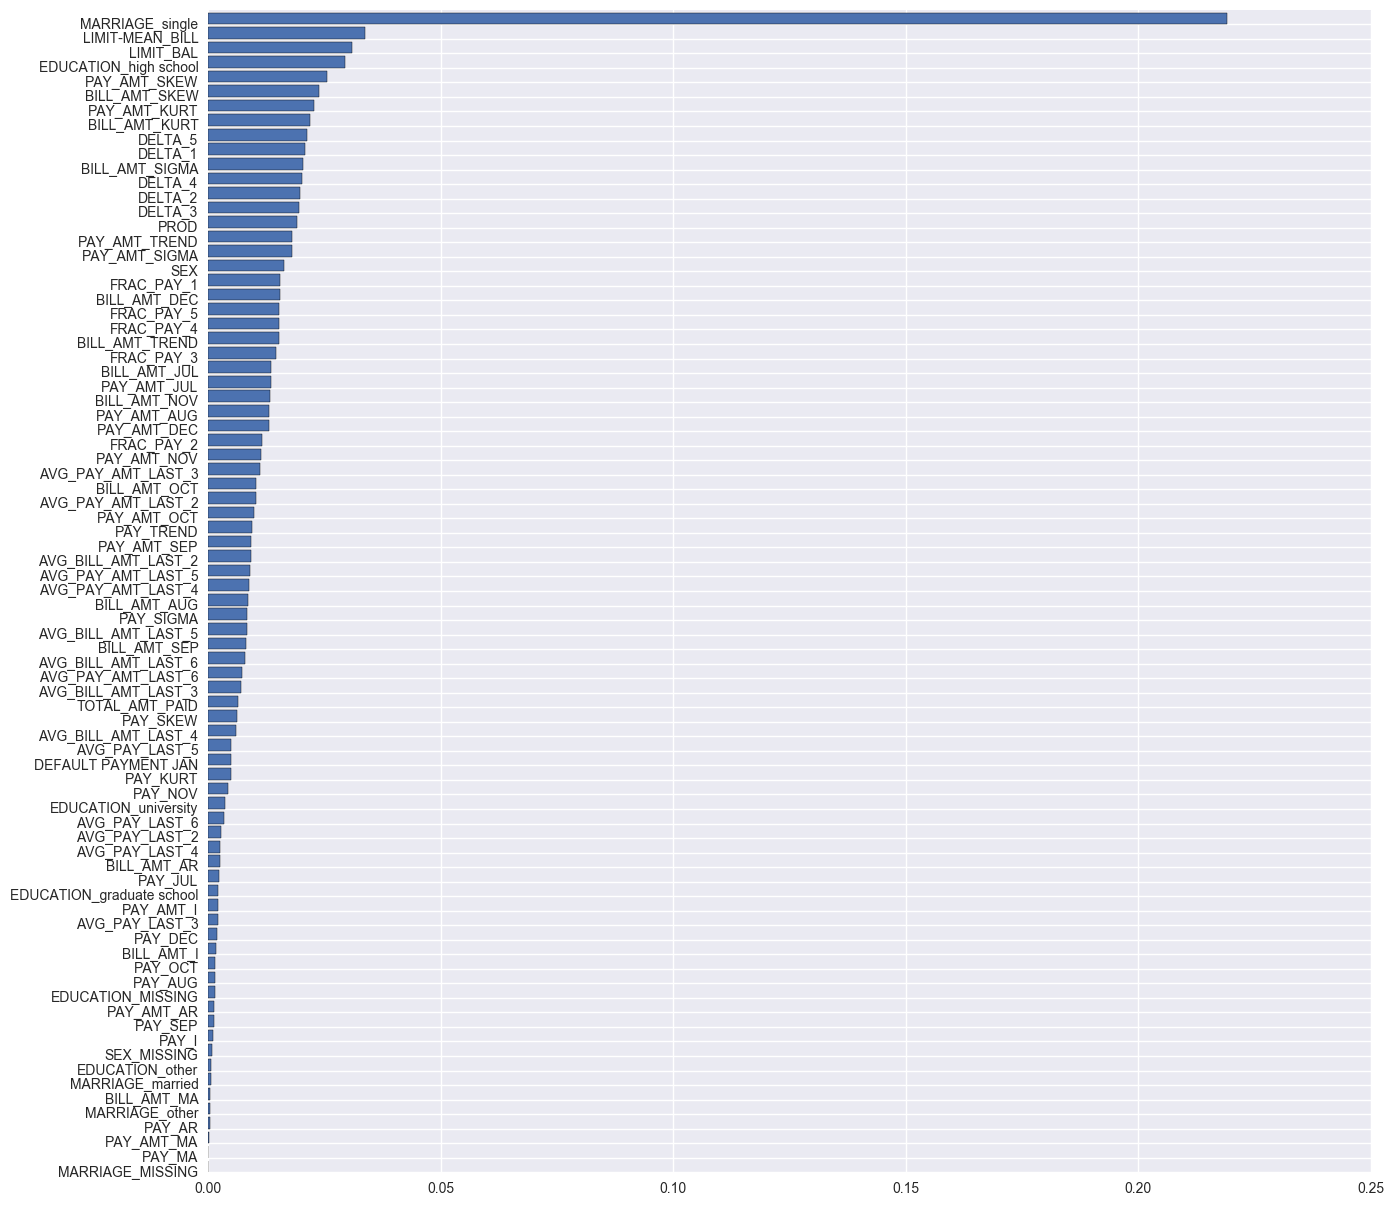

In [34]:
feature_impo_graph(model)

In [35]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
#EXTRATREESREGRESSOR feature selection
extra_model =  ExtraTreesRegressor(random_state=1234)
extra_model=extra_model.fit(train_not_ma_x,train_not_ma_y)

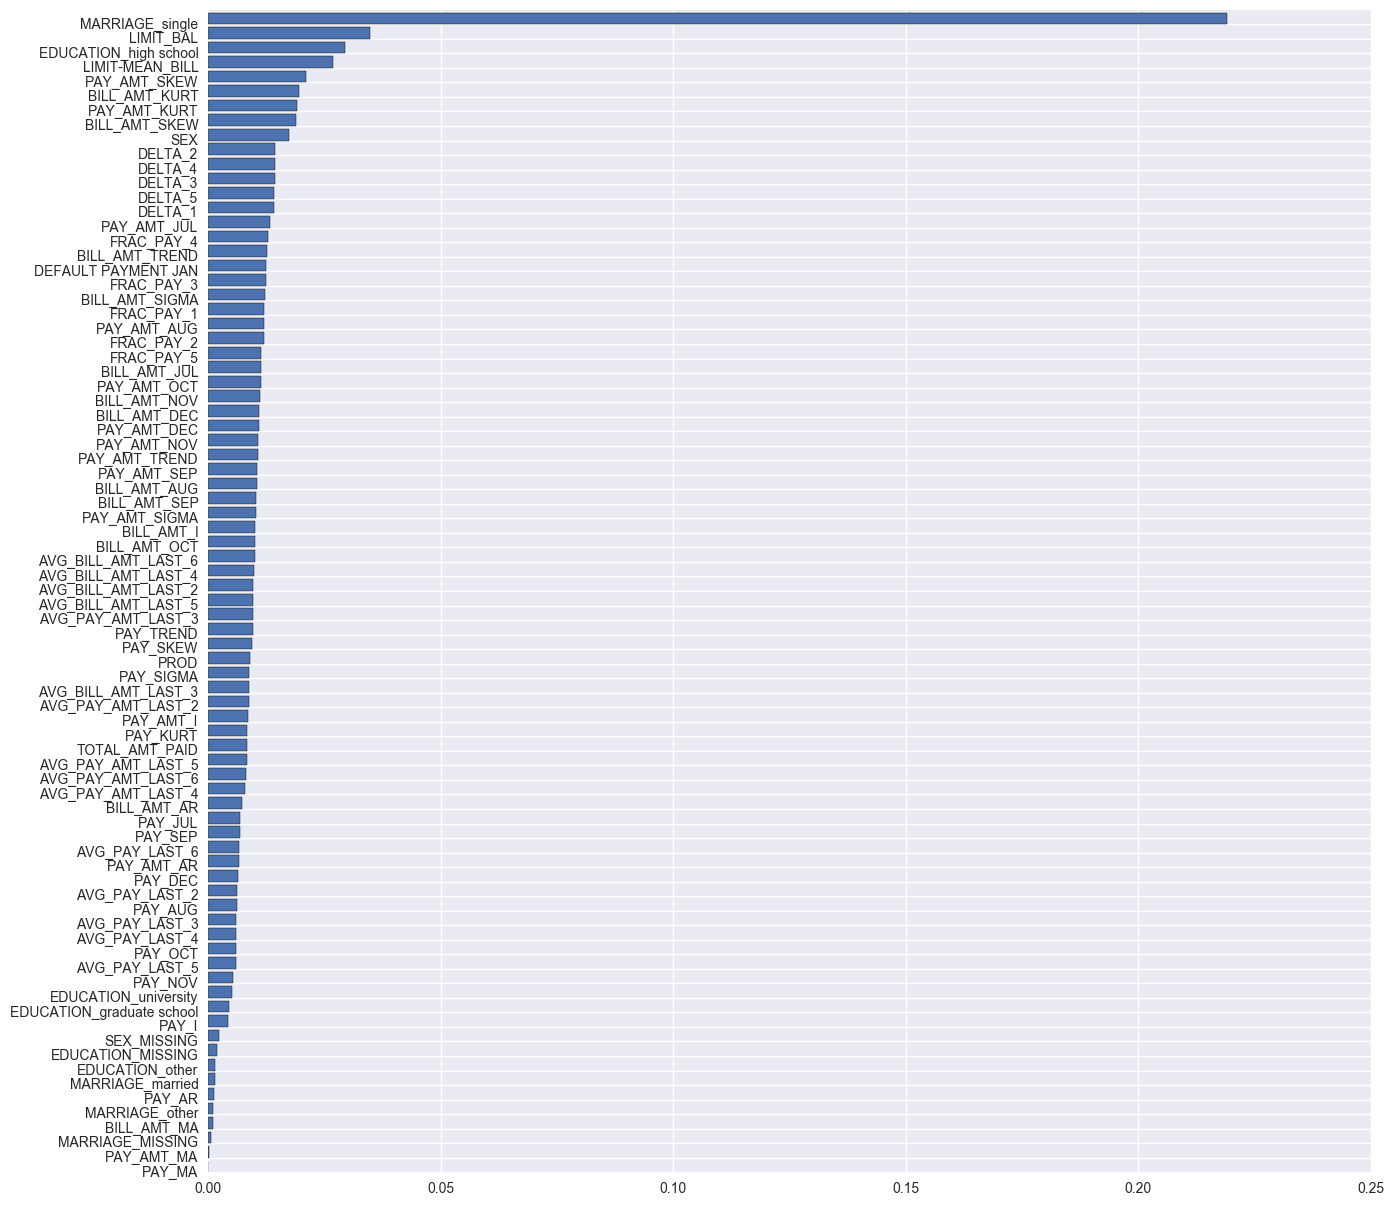

In [36]:
feature_impo_graph(extra_model)

In [37]:
train_ma=train.loc[train["AGE_MISSING"]==1]

In [38]:
train_not_ma_X=train_not_ma[['MARRIAGE_single','LIMIT-MEAN_BILL','EDUCATION_high school',
 'LIMIT_BAL','PAY_AMT_SKEW',
 'BILL_AMT_SKEW',
 'BILL_AMT_KURT',
 'PAY_AMT_KURT','DELTA_5',
 'SEX',
 'DELTA_1',
 'DELTA_2',
 'BILL_AMT_SIGMA',
 'DELTA_4','DELTA_3',
 'PROD',
 'PAY_AMT_JUL',
 'PAY_AMT_TREND',
 'FRAC_PAY_4',
 'PAY_AMT_SIGMA',
 'BILL_AMT_TREND','DEFAULT PAYMENT JAN',
 'FRAC_PAY_1',
 'FRAC_PAY_3',
 'BILL_AMT_DEC',
 'FRAC_PAY_5',
 'FRAC_PAY_4',
 'PAY_AMT_AUG','FRAC_PAY_2','BILL_AMT_JUL',
 'PAY_AMT_JUL',
 'PAY_AMT_OCT',
 'BILL_AMT_NOV',
 'PAY_AMT_DEC',
 'PAY_AMT_NOV','AVG_PAY_AMT_LAST_3',
 'PAY_AMT_SEP',
 'BILL_AMT_OCT',
 'BILL_AMT_AUG','AVG_PAY_AMT_LAST_2',
 'BILL_AMT_SEP', 'PAY_TREND',
 'BILL_AMT_I','AVG_BILL_AMT_LAST_2',
 'AVG_BILL_AMT_LAST_6',
 'AVG_PAY_AMT_LAST_5',
 'AVG_BILL_AMT_LAST_4','AVG_BILL_AMT_LAST_2']]
test_ma_X=train_ma[['MARRIAGE_single','LIMIT-MEAN_BILL','EDUCATION_high school',
 'LIMIT_BAL','PAY_AMT_SKEW',
 'BILL_AMT_SKEW',
 'BILL_AMT_KURT',
 'PAY_AMT_KURT','DELTA_5',
 'SEX',
 'DELTA_1',
 'DELTA_2',
 'BILL_AMT_SIGMA',
 'DELTA_4','DELTA_3',
 'PROD',
 'PAY_AMT_JUL',
 'PAY_AMT_TREND',
 'FRAC_PAY_4',
 'PAY_AMT_SIGMA',
 'BILL_AMT_TREND','DEFAULT PAYMENT JAN',
 'FRAC_PAY_1',
 'FRAC_PAY_3',
 'BILL_AMT_DEC',
 'FRAC_PAY_5',
 'FRAC_PAY_4',
 'PAY_AMT_AUG','FRAC_PAY_2','BILL_AMT_JUL',
 'PAY_AMT_JUL',
 'PAY_AMT_OCT',
 'BILL_AMT_NOV',
 'PAY_AMT_DEC',
 'PAY_AMT_NOV','AVG_PAY_AMT_LAST_3',
 'PAY_AMT_SEP',
 'BILL_AMT_OCT',
 'BILL_AMT_AUG','AVG_PAY_AMT_LAST_2',
 'BILL_AMT_SEP', 'PAY_TREND',
 'BILL_AMT_I','AVG_BILL_AMT_LAST_2',
 'AVG_BILL_AMT_LAST_6',
 'AVG_PAY_AMT_LAST_5',
 'AVG_BILL_AMT_LAST_4','AVG_BILL_AMT_LAST_2']]
test_ma_Y=train_ma["AGE"].ravel()

In [39]:
from sklearn.preprocessing import StandardScaler
x_train_not_ma_tr=StandardScaler().fit_transform(train_not_ma_X)

In [40]:
from sklearn.model_selection import train_test_split
x_train_not_ma, x_validation_not_ma, y_train_not_ma, y_validation_not_ma = train_test_split(x_train_not_ma_tr, 
                                            train_not_ma_y, test_size=0.3, random_state=4321)


In [41]:
from sklearn.neighbors import KNeighborsRegressor
regressor=KNeighborsRegressor()
regressor.fit(x_train_not_ma,y_train_not_ma)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [42]:
test_ma_X_tr=StandardScaler().fit_transform(test_ma_X)

In [43]:
predicted_age=regressor.predict(test_ma_X_tr)
predicted_age

array([ 36.8,  44.4,  28.6,  32.2,  35.2,  39.2,  41.6,  39.6,  36.8,
        37.8,  26.8,  30. ,  28.6,  34. ,  31.2,  31.2,  32.4,  29.8,
        31.4,  32.2,  31. ,  26.2,  36. ,  45.8,  33. ,  34.4,  38.2,
        32.8,  28.2,  34.4,  37.2,  38.6,  29.4,  32.6,  44.6,  39. ,
        24. ,  31.4,  33.4,  38.4,  34. ,  38.6,  34. ,  27.4,  31.4,
        40.6,  38.6,  42.2,  34.6,  38.6,  31.2,  46.4,  45.8,  30.8,
        35.8,  26.2,  35.2,  31.4,  27.2,  36.4,  35.8,  40.6,  32.2,
        36. ,  33. ,  28.2,  48.4,  33. ,  31.6,  37.8,  28. ,  41.4,
        39.2,  29. ,  41.2,  31.4,  36.2,  40.8,  28.8,  39.6,  31.6,
        37.6,  38. ,  37.4,  35.8,  45.6,  39. ,  26.8,  36.2,  27.8,
        30.6,  40.8,  37.6,  36.4,  51.2,  32.6,  32.4,  36.6,  24.8,
        37.6,  43.2,  33. ,  30.4,  34. ,  34.8,  32. ,  46.6,  42.4,
        29.8,  42.8,  46. ,  42.8,  41. ,  41. ,  38.8,  36.4,  39.4,
        36.2,  27.8,  41. ,  41. ,  32.2,  43.2,  46. ,  32.8,  46.2,
        33.8,  43. ,

In [44]:
l=[]
c=0
for row in train.itertuples():
    if(row.AGE_MISSING==1):
        l.append(predicted_age[c])
        c+=1
    else:
        l.append(0)

In [45]:
train["AGE_PREDICTED"]=l

In [46]:
k=[]
for row in train.itertuples():
    if(row.AGE_PREDICTED==0.0):
        k.append(row.AGE)
    else:
        k.append(row.AGE_PREDICTED.astype(int))

In [47]:
train["AGE_FINAL"]=k
train["AGE_FINAL"]=train.AGE_FINAL.astype(float)

In [48]:
train=train.drop(["AGE_PREDICTED","AGE","AGE_MISSING"],axis=1)
train["AGE"]=train["AGE_FINAL"]
train=train.drop(["AGE_FINAL"],axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26884 entries, 0 to 26883
Data columns (total 82 columns):
CUST_COD                     26884 non-null float64
LIMIT_BAL                    26884 non-null float64
SEX                          26884 non-null float64
PAY_DEC                      26884 non-null float64
PAY_NOV                      26884 non-null float64
PAY_OCT                      26884 non-null float64
PAY_SEP                      26884 non-null float64
PAY_AUG                      26884 non-null float64
PAY_JUL                      26884 non-null float64
BILL_AMT_DEC                 26884 non-null float64
BILL_AMT_NOV                 26884 non-null float64
BILL_AMT_OCT                 26884 non-null float64
BILL_AMT_SEP                 26884 non-null float64
BILL_AMT_AUG                 26884 non-null float64
BILL_AMT_JUL                 26884 non-null float64
PAY_AMT_DEC                  26884 non-null float64
PAY_AMT_NOV                  26884 non-null float64
PAY_AMT

In [49]:
train.to_csv("data/train_predictedAge.csv",index=False)

# Comparison between train and test

In [50]:
diff_mean = train.mean() - test.mean()

In [51]:
train[pay_amt_cols].mean()

PAY_AMT_JUL    157.534344
PAY_AMT_AUG    144.259750
PAY_AMT_SEP    144.518815
PAY_AMT_OCT    156.416357
PAY_AMT_NOV    178.825861
PAY_AMT_DEC    168.639427
dtype: float64

In [52]:
test[pay_amt_cols].mean()

PAY_AMT_JUL    137.879949
PAY_AMT_AUG    132.969058
PAY_AMT_SEP    138.394712
PAY_AMT_OCT    150.447367
PAY_AMT_NOV    156.733492
PAY_AMT_DEC    170.683358
dtype: float64

In [53]:
for colname, value in zip(diff_mean.index, diff_mean):
    print("{0}{1:.2f}".format(colname.ljust(30), value))

AGE                           -0.03
AGE_MISSING                   nan
AVG_BILL_AMT_LAST_2           18.25
AVG_BILL_AMT_LAST_3           20.30
AVG_BILL_AMT_LAST_4           21.30
AVG_BILL_AMT_LAST_5           21.18
AVG_BILL_AMT_LAST_6           18.65
AVG_PAY_AMT_LAST_2            10.02
AVG_PAY_AMT_LAST_3            8.67
AVG_PAY_AMT_LAST_4            8.04
AVG_PAY_AMT_LAST_5            8.69
AVG_PAY_AMT_LAST_6            10.51
AVG_PAY_LAST_2                0.00
AVG_PAY_LAST_3                0.00
AVG_PAY_LAST_4                0.01
AVG_PAY_LAST_5                0.01
AVG_PAY_LAST_6                0.00
BILL_AMT_AR                   0.00
BILL_AMT_AUG                  20.70
BILL_AMT_DEC                  28.74
BILL_AMT_I                    -0.00
BILL_AMT_JUL                  5.99
BILL_AMT_KURT                 0.05
BILL_AMT_MA                   0.00
BILL_AMT_NOV                  7.77
BILL_AMT_OCT                  24.41
BILL_AMT_SEP                  24.28
BILL_AMT_SIGMA                6.60
BILL_AMT

Nel test:
- Tendono a pagare in media molto più tardi rispetto ai dati nel train
- Hanno un BILL_AMT che è in genere un po' più basso
- Tendono a pagare un po' meno mensilmente
- Non ci sono differenze significative per età, sesso ed educazione

# [OPTIONAL] Categorize data

In [54]:
train = pd.read_csv('data/train_all_features.csv')
test = pd.read_csv('data/test_all_features.csv')

In [55]:
def get_qcut_tuples(df, q):
    bins = np.unique(pd.qcut(df, q))
    bin_tuples = [tuple(map(float, x[1:-1].split(','))) for x in bins]
    return sorted(bin_tuples)

In [56]:
traintest = pd.concat([train, test])

## Age

In [57]:
AGE_CUTS = 11

age_bins = [x[0] for x in get_qcut_tuples(traintest['AGE'], AGE_CUTS)] + [np.inf]

for df in [train,test]:
    df['AGE'] = pd.cut(df['AGE'], bins=age_bins, right=True, include_lowest=True, labels=np.arange(AGE_CUTS))

## LIMIT_BAL

In [58]:
LIMIT_BAL_CUTS = 11

limit_bal_bins = [x[0] for x in get_qcut_tuples(traintest['LIMIT_BAL'], LIMIT_BAL_CUTS)] + [np.inf]

for df in [train, test]:
    df['LIMIT_BAL'] = pd.cut(df['LIMIT_BAL'], bins=limit_bal_bins, right=True, include_lowest=True, labels=np.arange(LIMIT_BAL_CUTS))

In [59]:
for df in [train, test]:
    for c in pay_cols:
        train[c] = pd.cut(train[c], bins=[-2, -1, 0, 2, 9], labels=[-2, -1, 0, 2], include_lowest=True)
    for c in avg_pay_last:
        train[c] = pd.cut(train[c], bins=[-2, -1, 0, 2, 9], labels=[-2, -1, 0, 2], include_lowest=True)

## SIGMA

In [60]:
PAY_AMT_SIGMA_CUTS = 10
pay_amt_sigma_bins = [x[0] for x in get_qcut_tuples(traintest['PAY_AMT_SIGMA'], PAY_AMT_SIGMA_CUTS)] + [np.inf]
for df in [train, test]:
    df['PAY_AMT_SIGMA'] = pd.cut(df['PAY_AMT_SIGMA'], bins=pay_amt_sigma_bins, right=True, include_lowest=True, labels=np.arange(PAY_AMT_SIGMA_CUTS))

In [61]:
BILL_AMT_SIGMA_CUTS = 10
bill_amt_sigma_bins = [x[0] for x in get_qcut_tuples(traintest['BILL_AMT_SIGMA'], BILL_AMT_SIGMA_CUTS)] + [np.inf]
for df in [train, test]:
    df['BILL_AMT_SIGMA'] = pd.cut(df['BILL_AMT_SIGMA'], bins=bill_amt_sigma_bins, right=True, include_lowest=True, labels=np.arange(BILL_AMT_SIGMA_CUTS))